<a href="https://colab.research.google.com/github/TIMEdilation584/JP_Loksatta_moving_hearts/blob/master/19_07_22_ast_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# -*- coding: utf-8 -*-
# @Time    : 6/24/21 12:50 AM
# @Author  : Yuan Gong
# @Affiliation  : Massachusetts Institute of Technology
# @Email   : yuangong@mit.edu
# @File    : demo.py

import os
import torch
from models import ASTModel
# download pretrained model in this directory
os.environ['TORCH_HOME'] = '../pretrained_models'
# assume each input spectrogram has 100 time frames
input_tdim = 100
# assume the task has 527 classes
label_dim = 527
# create a pseudo input: a batch of 10 spectrogram, each with 100 time frames and 128 frequency bins
test_input = torch.rand([10, input_tdim, 128])
# create an AST model
ast_mdl = ASTModel(label_dim=label_dim, input_tdim=input_tdim, imagenet_pretrain=True, audioset_pretrain=True)
test_output = ast_mdl(test_input)
# output should be in shape [10, 527], i.e., 10 samples, each with prediction of 527 classes.
print(test_output.shape)

ModuleNotFoundError: ignored

In [3]:
!git clone https://github.com/YuanGongND/ast.git

fatal: destination path 'ast' already exists and is not an empty directory.


In [4]:
cd ast/ 

/content/ast


In [ ]:
!pip install virtualenv

In [ ]:
!virtualenv venvast

In [8]:
!source venvast/bin/activate

In [ ]:
!pip install -r requirements.txt

In [ ]:

# -*- coding: utf-8 -*-
# @Time    : 6/19/21 4:31 PM
# @Author  : Yuan Gong
# @Affiliation  : Massachusetts Institute of Technology
# @Email   : yuangong@mit.edu
# @File    : __init__.py



In [11]:
from .ast_models import *

ImportError: ignored

In [13]:
# -*- coding: utf-8 -*-
# @Time    : 6/10/21 5:04 PM
# @Author  : Yuan Gong
# @Affiliation  : Massachusetts Institute of Technology
# @Email   : yuangong@mit.edu
# @File    : ast_models.py

import torch
import torch.nn as nn
from torch.cuda.amp import autocast
import os
import wget
os.environ['TORCH_HOME'] = '../../pretrained_models'
import timm
from timm.models.layers import to_2tuple,trunc_normal_

# override the timm package to relax the input shape constraint.
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()

        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class ASTModel(nn.Module):
    """
    The AST model.
    :param label_dim: the label dimension, i.e., the number of total classes, it is 527 for AudioSet, 50 for ESC-50, and 35 for speechcommands v2-35
    :param fstride: the stride of patch spliting on the frequency dimension, for 16*16 patchs, fstride=16 means no overlap, fstride=10 means overlap of 6
    :param tstride: the stride of patch spliting on the time dimension, for 16*16 patchs, tstride=16 means no overlap, tstride=10 means overlap of 6
    :param input_fdim: the number of frequency bins of the input spectrogram
    :param input_tdim: the number of time frames of the input spectrogram
    :param imagenet_pretrain: if use ImageNet pretrained model
    :param audioset_pretrain: if use full AudioSet and ImageNet pretrained model
    :param model_size: the model size of AST, should be in [tiny224, small224, base224, base384], base224 and base 384 are same model, but are trained differently during ImageNet pretraining.
    """
    def __init__(self, label_dim=527, fstride=10, tstride=10, input_fdim=128, input_tdim=1024, imagenet_pretrain=True, audioset_pretrain=False, model_size='base384', verbose=True):

        super(ASTModel, self).__init__()
        assert timm.__version__ == '0.4.5', 'Please use timm == 0.4.5, the code might not be compatible with newer versions.'

        if verbose == True:
            print('---------------AST Model Summary---------------')
            print('ImageNet pretraining: {:s}, AudioSet pretraining: {:s}'.format(str(imagenet_pretrain),str(audioset_pretrain)))
        # override timm input shape restriction
        timm.models.vision_transformer.PatchEmbed = PatchEmbed

        # if AudioSet pretraining is not used (but ImageNet pretraining may still apply)
        if audioset_pretrain == False:
            if model_size == 'tiny224':
                self.v = timm.create_model('vit_deit_tiny_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'small224':
                self.v = timm.create_model('vit_deit_small_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'base224':
                self.v = timm.create_model('vit_deit_base_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'base384':
                self.v = timm.create_model('vit_deit_base_distilled_patch16_384', pretrained=imagenet_pretrain)
            else:
                raise Exception('Model size must be one of tiny224, small224, base224, base384.')
            self.original_num_patches = self.v.patch_embed.num_patches
            self.oringal_hw = int(self.original_num_patches ** 0.5)
            self.original_embedding_dim = self.v.pos_embed.shape[2]
            self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim), nn.Linear(self.original_embedding_dim, label_dim))

            # automatcially get the intermediate shape
            f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
            num_patches = f_dim * t_dim
            self.v.patch_embed.num_patches = num_patches
            if verbose == True:
                print('frequncey stride={:d}, time stride={:d}'.format(fstride, tstride))
                print('number of patches={:d}'.format(num_patches))

            # the linear projection layer
            new_proj = torch.nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
            if imagenet_pretrain == True:
                new_proj.weight = torch.nn.Parameter(torch.sum(self.v.patch_embed.proj.weight, dim=1).unsqueeze(1))
                new_proj.bias = self.v.patch_embed.proj.bias
            self.v.patch_embed.proj = new_proj

            # the positional embedding
            if imagenet_pretrain == True:
                # get the positional embedding from deit model, skip the first two tokens (cls token and distillation token), reshape it to original 2D shape (24*24).
                new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, self.original_num_patches, self.original_embedding_dim).transpose(1, 2).reshape(1, self.original_embedding_dim, self.oringal_hw, self.oringal_hw)
                # cut (from middle) or interpolate the second dimension of the positional embedding
                if t_dim <= self.oringal_hw:
                    new_pos_embed = new_pos_embed[:, :, :, int(self.oringal_hw / 2) - int(t_dim / 2): int(self.oringal_hw / 2) - int(t_dim / 2) + t_dim]
                else:
                    new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(self.oringal_hw, t_dim), mode='bilinear')
                # cut (from middle) or interpolate the first dimension of the positional embedding
                if f_dim <= self.oringal_hw:
                    new_pos_embed = new_pos_embed[:, :, int(self.oringal_hw / 2) - int(f_dim / 2): int(self.oringal_hw / 2) - int(f_dim / 2) + f_dim, :]
                else:
                    new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(f_dim, t_dim), mode='bilinear')
                # flatten the positional embedding
                new_pos_embed = new_pos_embed.reshape(1, self.original_embedding_dim, num_patches).transpose(1,2)
                # concatenate the above positional embedding with the cls token and distillation token of the deit model.
                self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))
            else:
                # if not use imagenet pretrained model, just randomly initialize a learnable positional embedding
                # TODO can use sinusoidal positional embedding instead
                new_pos_embed = nn.Parameter(torch.zeros(1, self.v.patch_embed.num_patches + 2, self.original_embedding_dim))
                self.v.pos_embed = new_pos_embed
                trunc_normal_(self.v.pos_embed, std=.02)

        # now load a model that is pretrained on both ImageNet and AudioSet
        elif audioset_pretrain == True:
            if audioset_pretrain == True and imagenet_pretrain == False:
                raise ValueError('currently model pretrained on only audioset is not supported, please set imagenet_pretrain = True to use audioset pretrained model.')
            if model_size != 'base384':
                raise ValueError('currently only has base384 AudioSet pretrained model.')
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            if os.path.exists('../../pretrained_models/audioset_10_10_0.4593.pth') == False:
                # this model performs 0.4593 mAP on the audioset eval set
                audioset_mdl_url = 'https://www.dropbox.com/s/cv4knew8mvbrnvq/audioset_0.4593.pth?dl=1'
                wget.download(audioset_mdl_url, out='../../pretrained_models/audioset_10_10_0.4593.pth')
            sd = torch.load('../../pretrained_models/audioset_10_10_0.4593.pth', map_location=device)
            audio_model = ASTModel(label_dim=527, fstride=10, tstride=10, input_fdim=128, input_tdim=1024, imagenet_pretrain=False, audioset_pretrain=False, model_size='base384', verbose=False)
            audio_model = torch.nn.DataParallel(audio_model)
            audio_model.load_state_dict(sd, strict=False)
            self.v = audio_model.module.v
            self.original_embedding_dim = self.v.pos_embed.shape[2]
            self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim), nn.Linear(self.original_embedding_dim, label_dim))

            f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
            num_patches = f_dim * t_dim
            self.v.patch_embed.num_patches = num_patches
            if verbose == True:
                print('frequncey stride={:d}, time stride={:d}'.format(fstride, tstride))
                print('number of patches={:d}'.format(num_patches))

            new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, 1212, 768).transpose(1, 2).reshape(1, 768, 12, 101)
            # if the input sequence length is larger than the original audioset (10s), then cut the positional embedding
            if t_dim < 101:
                new_pos_embed = new_pos_embed[:, :, :, 50 - int(t_dim/2): 50 - int(t_dim/2) + t_dim]
            # otherwise interpolate
            else:
                new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(12, t_dim), mode='bilinear')
            if f_dim < 12:
                new_pos_embed = new_pos_embed[:, :, 6 - int(f_dim/2): 6 - int(f_dim/2) + f_dim, :]
            # otherwise interpolate
            elif f_dim > 12:
                new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(f_dim, t_dim), mode='bilinear')
            new_pos_embed = new_pos_embed.reshape(1, 768, num_patches).transpose(1, 2)
            self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))

    def get_shape(self, fstride, tstride, input_fdim=128, input_tdim=1024):
        test_input = torch.randn(1, 1, input_fdim, input_tdim)
        test_proj = nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
        test_out = test_proj(test_input)
        f_dim = test_out.shape[2]
        t_dim = test_out.shape[3]
        return f_dim, t_dim

    @autocast()
    def forward(self, x):
        """
        :param x: the input spectrogram, expected shape: (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        :return: prediction
        """
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        for blk in self.v.blocks:
            x = blk(x)
        x = self.v.norm(x)
        x = (x[:, 0] + x[:, 1]) / 2

        x = self.mlp_head(x)
        return x

if __name__ == '__main__':
    input_tdim = 100
    ast_mdl = ASTModel(input_tdim=input_tdim)
    # input a batch of 10 spectrogram, each with 100 time frames and 128 frequency bins
    test_input = torch.rand([10, input_tdim, 128])
    test_output = ast_mdl(test_input)
    # output should be in shape [10, 527], i.e., 10 samples, each with prediction of 527 classes.
    print(test_output.shape)

    input_tdim = 256
    ast_mdl = ASTModel(input_tdim=input_tdim,label_dim=50, audioset_pretrain=True)
    # input a batch of 10 spectrogram, each with 512 time frames and 128 frequency bins
    test_input = torch.rand([10, input_tdim, 128])
    test_output = ast_mdl(test_input)
    # output should be in shape [10, 50], i.e., 10 samples, each with prediction of 50 classes.
    print(test_output.shape)

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: False


Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_distilled_patch16_384-d0272ac0.pth" to ../../pretrained_models/hub/checkpoints/deit_base_distilled_patch16_384-d0272ac0.pth


frequncey stride=10, time stride=10
number of patches=108
torch.Size([10, 527])
---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: True
frequncey stride=10, time stride=10
number of patches=300
torch.Size([10, 50])


In [15]:

import torch
import torch.nn as nn
from torch.cuda.amp import autocast
import os
import wget
os.environ['TORCH_HOME'] = '../../pretrained_models'
import timm
from timm.models.layers import to_2tuple,trunc_normal_

# override the timm package to relax the input shape constraint.
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()

        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class ASTModel(nn.Module):
    """
    The AST model.
    :param label_dim: the label dimension, i.e., the number of total classes, it is 527 for AudioSet, 50 for ESC-50, and 35 for speechcommands v2-35
    :param fstride: the stride of patch spliting on the frequency dimension, for 16*16 patchs, fstride=16 means no overlap, fstride=10 means overlap of 6
    :param tstride: the stride of patch spliting on the time dimension, for 16*16 patchs, tstride=16 means no overlap, tstride=10 means overlap of 6
    :param input_fdim: the number of frequency bins of the input spectrogram
    :param input_tdim: the number of time frames of the input spectrogram
    :param imagenet_pretrain: if use ImageNet pretrained model
    :param audioset_pretrain: if use full AudioSet and ImageNet pretrained model
    :param model_size: the model size of AST, should be in [tiny224, small224, base224, base384], base224 and base 384 are same model, but are trained differently during ImageNet pretraining.
    """
    def __init__(self, label_dim=527, fstride=10, tstride=10, input_fdim=128, input_tdim=1024, imagenet_pretrain=True, audioset_pretrain=False, model_size='base384', verbose=True):

        super(ASTModel, self).__init__()
        assert timm.__version__ == '0.4.5', 'Please use timm == 0.4.5, the code might not be compatible with newer versions.'

        if verbose == True:
            print('---------------AST Model Summary---------------')
            print('ImageNet pretraining: {:s}, AudioSet pretraining: {:s}'.format(str(imagenet_pretrain),str(audioset_pretrain)))
        # override timm input shape restriction
        timm.models.vision_transformer.PatchEmbed = PatchEmbed

        # if AudioSet pretraining is not used (but ImageNet pretraining may still apply)
        if audioset_pretrain == False:
            if model_size == 'tiny224':
                self.v = timm.create_model('vit_deit_tiny_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'small224':
                self.v = timm.create_model('vit_deit_small_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'base224':
                self.v = timm.create_model('vit_deit_base_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'base384':
                self.v = timm.create_model('vit_deit_base_distilled_patch16_384', pretrained=imagenet_pretrain)
            else:
                raise Exception('Model size must be one of tiny224, small224, base224, base384.')
            self.original_num_patches = self.v.patch_embed.num_patches
            self.oringal_hw = int(self.original_num_patches ** 0.5)
            self.original_embedding_dim = self.v.pos_embed.shape[2]
            self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim), nn.Linear(self.original_embedding_dim, label_dim))

            # automatcially get the intermediate shape
            f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
            num_patches = f_dim * t_dim
            self.v.patch_embed.num_patches = num_patches
            if verbose == True:
                print('frequncey stride={:d}, time stride={:d}'.format(fstride, tstride))
                print('number of patches={:d}'.format(num_patches))

            # the linear projection layer
            new_proj = torch.nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
            if imagenet_pretrain == True:
                new_proj.weight = torch.nn.Parameter(torch.sum(self.v.patch_embed.proj.weight, dim=1).unsqueeze(1))
                new_proj.bias = self.v.patch_embed.proj.bias
            self.v.patch_embed.proj = new_proj

            # the positional embedding
            if imagenet_pretrain == True:
                # get the positional embedding from deit model, skip the first two tokens (cls token and distillation token), reshape it to original 2D shape (24*24).
                new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, self.original_num_patches, self.original_embedding_dim).transpose(1, 2).reshape(1, self.original_embedding_dim, self.oringal_hw, self.oringal_hw)
                # cut (from middle) or interpolate the second dimension of the positional embedding
                if t_dim <= self.oringal_hw:
                    new_pos_embed = new_pos_embed[:, :, :, int(self.oringal_hw / 2) - int(t_dim / 2): int(self.oringal_hw / 2) - int(t_dim / 2) + t_dim]
                else:
                    new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(self.oringal_hw, t_dim), mode='bilinear')
                # cut (from middle) or interpolate the first dimension of the positional embedding
                if f_dim <= self.oringal_hw:
                    new_pos_embed = new_pos_embed[:, :, int(self.oringal_hw / 2) - int(f_dim / 2): int(self.oringal_hw / 2) - int(f_dim / 2) + f_dim, :]
                else:
                    new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(f_dim, t_dim), mode='bilinear')
                # flatten the positional embedding
                new_pos_embed = new_pos_embed.reshape(1, self.original_embedding_dim, num_patches).transpose(1,2)
                # concatenate the above positional embedding with the cls token and distillation token of the deit model.
                self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))
            else:
                # if not use imagenet pretrained model, just randomly initialize a learnable positional embedding
                # TODO can use sinusoidal positional embedding instead
                new_pos_embed = nn.Parameter(torch.zeros(1, self.v.patch_embed.num_patches + 2, self.original_embedding_dim))
                self.v.pos_embed = new_pos_embed
                trunc_normal_(self.v.pos_embed, std=.02)

        # now load a model that is pretrained on both ImageNet and AudioSet
        elif audioset_pretrain == True:
            if audioset_pretrain == True and imagenet_pretrain == False:
                raise ValueError('currently model pretrained on only audioset is not supported, please set imagenet_pretrain = True to use audioset pretrained model.')
            if model_size != 'base384':
                raise ValueError('currently only has base384 AudioSet pretrained model.')
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            if os.path.exists('../../pretrained_models/audioset_10_10_0.4593.pth') == False:
                # this model performs 0.4593 mAP on the audioset eval set
                audioset_mdl_url = 'https://www.dropbox.com/s/cv4knew8mvbrnvq/audioset_0.4593.pth?dl=1'
                wget.download(audioset_mdl_url, out='../../pretrained_models/audioset_10_10_0.4593.pth')
            sd = torch.load('../../pretrained_models/audioset_10_10_0.4593.pth', map_location=device)
            audio_model = ASTModel(label_dim=527, fstride=10, tstride=10, input_fdim=128, input_tdim=1024, imagenet_pretrain=False, audioset_pretrain=False, model_size='base384', verbose=False)
            audio_model = torch.nn.DataParallel(audio_model)
            audio_model.load_state_dict(sd, strict=False)
            self.v = audio_model.module.v
            self.original_embedding_dim = self.v.pos_embed.shape[2]
            self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim), nn.Linear(self.original_embedding_dim, label_dim))

            f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
            num_patches = f_dim * t_dim
            self.v.patch_embed.num_patches = num_patches
            if verbose == True:
                print('frequncey stride={:d}, time stride={:d}'.format(fstride, tstride))
                print('number of patches={:d}'.format(num_patches))

            new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, 1212, 768).transpose(1, 2).reshape(1, 768, 12, 101)
            # if the input sequence length is larger than the original audioset (10s), then cut the positional embedding
            if t_dim < 101:
                new_pos_embed = new_pos_embed[:, :, :, 50 - int(t_dim/2): 50 - int(t_dim/2) + t_dim]
            # otherwise interpolate
            else:
                new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(12, t_dim), mode='bilinear')
            if f_dim < 12:
                new_pos_embed = new_pos_embed[:, :, 6 - int(f_dim/2): 6 - int(f_dim/2) + f_dim, :]
            # otherwise interpolate
            elif f_dim > 12:
                new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(f_dim, t_dim), mode='bilinear')
            new_pos_embed = new_pos_embed.reshape(1, 768, num_patches).transpose(1, 2)
            self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))

    def get_shape(self, fstride, tstride, input_fdim=128, input_tdim=1024):
        test_input = torch.randn(1, 1, input_fdim, input_tdim)
        test_proj = nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
        test_out = test_proj(test_input)
        f_dim = test_out.shape[2]
        t_dim = test_out.shape[3]
        return f_dim, t_dim

    @autocast()
    def forward(self, x):
        """
        :param x: the input spectrogram, expected shape: (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        :return: prediction
        """
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        for blk in self.v.blocks:
            x = blk(x)
        x = self.v.norm(x)
        x = (x[:, 0] + x[:, 1]) / 2

        x = self.mlp_head(x)
        return x

if __name__ == '__main__':
    input_tdim = 100
    ast_mdl = ASTModel(input_tdim=input_tdim)
    # input a batch of 10 spectrogram, each with 100 time frames and 128 frequency bins
    test_input = torch.rand([10, input_tdim, 128])
    test_output = ast_mdl(test_input)
    # output should be in shape [10, 527], i.e., 10 samples, each with prediction of 527 classes.
    print(test_output.shape)

    input_tdim = 256
    ast_mdl = ASTModel(input_tdim=input_tdim,label_dim=50, audioset_pretrain=True)
    # input a batch of 10 spectrogram, each with 512 time frames and 128 frequency bins
    test_input = torch.rand([10, input_tdim, 128])
    test_output = ast_mdl(test_input)
    # output should be in shape [10, 50], i.e., 10 samples, each with prediction of 50 classes.
    print(test_output.shape)

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=108
torch.Size([10, 527])
---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: True
frequncey stride=10, time stride=10
number of patches=300
torch.Size([10, 50])


In [ ]:
ASTModel(label_dim=527, fshape=16, tshape=16 ,fstride=10, tstride=10, input_fdim=128, input_tdim=1024, model_size='base',
         pretrain_stage=True, load_pretrained_mdl_path=None)

In [ ]:
def input_to_target(base_data_path = '../data/'):

    # audio files and their corresponding labels
    train_path = base_data_path + "train/Train/*.wav"
    train_label_path = base_data_path +  "train.csv"
    test_path =  base_data_path + "test/Test/*.wav"


In [ ]:


import os 
import torch
#from models import ASTModel 
# download pretrained model in this directory
os.environ['TORCH_HOME'] = '../pretrained_models'  
# assume each input spectrogram has 100 time frames
input_tdim = 100
# assume the task has 527 classes
label_dim = 527
# create a pseudo input: a batch of 10 spectrogram, each with 100 time frames and 128 frequency bins 
test_input = torch.rand([10, input_tdim, 128]) 
# create an AST model
ast_mdl = ASTModel(label_dim=label_dim, input_tdim=input_tdim, imagenet_pretrain=True)
test_output = ast_mdl(test_input) 
# output should be in shape [10, 527], i.e., 10 samples, each with prediction of 527 classes. 
print(test_output.shape)  

In [22]:
from matplotlib import pyplot as plt


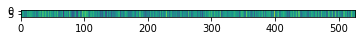

In [25]:
plt.imshow(test_output.cpu().detach().numpy())

In [27]:
import os
import sys
import csv
import argparse

import numpy as np
import torch
import torchaudio

torchaudio.set_audio_backend("soundfile")       # switch backend
basepath = os.path.dirname(os.path.dirname(sys.path[0]))
sys.path.append(basepath)
#from src.models import ASTModel

# download pretrained model in this directory
os.environ['TORCH_HOME'] = '../pretrained_models'


def make_features(wav_name, mel_bins, target_length=1024):
    waveform, sr = torchaudio.load(wav_name)

    fbank = torchaudio.compliance.kaldi.fbank(
        waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
        window_type='hanning', num_mel_bins=mel_bins, dither=0.0,
        frame_shift=10)

    n_frames = fbank.shape[0]

    p = target_length - n_frames
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:target_length, :]

    fbank = (fbank - (-4.2677393)) / (4.5689974 * 2)
    return fbank


def load_label(label_csv):
    with open(label_csv, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        lines = list(reader)
    labels = []
    ids = []  # Each label has a unique id such as "/m/068hy"
    for i1 in range(1, len(lines)):
        id = lines[i1][1]
        label = lines[i1][2]
        ids.append(id)
        labels.append(label)
    return labels


if __name__ == '__main__':

    parser = argparse.ArgumentParser(description='Example of parser:'
                                                 'python inference --audio_path ./0OxlgIitVig.wav '
                                                 '--model_path ./pretrained_models/audioset_10_10_0.4593.pth')

    parser.add_argument("--model_path", type=str, required=True,
                        help="the trained model you want to test")
    parser.add_argument('--audio_path',
                        help='the audio you want to predict, sample rate 16k.',
                        type=str, required=True)

    args = parser.parse_args()

    label_csv = './data/class_labels_indices.csv'       # label and indices for audioset data

    # 1. make feature for predict
    audio_path = args.audio_path
    feats = make_features(audio_path, mel_bins=128)           # shape(1024, 128)

    # assume each input spectrogram has 100 time frames
    input_tdim = feats.shape[0]

    # 2. load the best model and the weights
    checkpoint_path = args.model_path
    ast_mdl = ASTModel(label_dim=527, input_tdim=input_tdim, imagenet_pretrain=False, audioset_pretrain=False)
    print(f'[*INFO] load checkpoint: {checkpoint_path}')
    checkpoint = torch.load(checkpoint_path, map_location='cuda')
    audio_model = torch.nn.DataParallel(ast_mdl, device_ids=[0])
    audio_model.load_state_dict(checkpoint)

    audio_model = audio_model.to(torch.device("cuda:0"))

    # 3. feed the data feature to model
    feats_data = feats.expand(1, input_tdim, 128)           # reshape the feature

    audio_model.eval()                                      # set the eval model
    with torch.no_grad():
        output = audio_model.forward(feats_data)
        output = torch.sigmoid(output)
    result_output = output.data.cpu().numpy()[0]

    # 4. map the post-prob to label
    labels = load_label(label_csv)

    sorted_indexes = np.argsort(result_output)[::-1]

    # Print audio tagging top probabilities
    print('[*INFO] predice results:')
    for k in range(10):
        print('{}: {:.4f}'.format(np.array(labels)[sorted_indexes[k]],
                                  result_output[sorted_indexes[k]]))

usage: ipykernel_launcher.py [-h] --model_path MODEL_PATH --audio_path
                             AUDIO_PATH
ipykernel_launcher.py: error: the following arguments are required: --model_path, --audio_path


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
